In [1]:
import torch
from torch import nn
import torchtext
import numpy as np

import random
import math
from typing import Optional, List, Dict, Tuple, Iterable
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchinfo import summary

from torch.nn.utils.rnn import pad_sequence

# Building the Transformer

The transformer is broken down into the following parts:
* Embedding
    * Positional Embedding
    * Token Embedding
* Multihead Attention Block
    * Multihead attention
    * Residual Connection with normalization
* Position-Wise FeedForward Block
    * Fully connected block
    * Residual Connection with normalization
* Encoder Block: Input Embedding -> [MultiHeadAttention -> Position-Wise FeedForward Block] x N
* Decoder Block: Output Embedding -> [MaskedMultiHeadAttention -> CrossMultiHeadAttention -> Position-Wise FeedForward Block] x N
* Output of the transformer: Decoder output (logits) -> Feed Foward layer -> Softmax

## Embedding

In [2]:
class Embedding(nn.Module):

    def __init__(self,
                 d_model: int=512,
                 vocab_size: int=1000,
                 max_seq_len: int=10,
                 dropout: float=0.1):
        
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(num_embeddings=vocab_size,
                                      embedding_dim=d_model)
        self.pe = torch.zeros(max_seq_len, d_model, requires_grad=False)
        
        # calculating position embedding as it is does not vary depending on the input tokens
        for i in range(max_seq_len):
            for j in range(d_model):
                if j%2==0:
                    self.pe[i, j] = math.sin(i/(10000**(2*j/d_model)))
                else:
                    self.pe[i, j] = math.cos(i/(10000**(2*j/d_model)))
        
        self.pe = self.pe.unsqueeze(0)
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x -> [batch_size, seq_len]
        embed_out = self.embedding(x) # embed_out -> [batch_size, seq_len, ]
        return self.dropout(self.pe[:, embed_out.size(1), :] + embed_out)

## MultiHead Attention Block

### Multihead Attention Layer

In [3]:
class MultiHeadAttentionLayer(nn.Module):

    def __init__(self, 
                 d_model: int=512,
                 num_heads: int=8):
        
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads

        assert d_model%num_heads == 0, f"Dimensionality of the model {d_model} should be divisible by the number of heads {num_heads}"

        self.W_v = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_q = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
    
    @staticmethod
    def scaled_dot_product_attention(query: torch.Tensor,
                                     key: torch.Tensor,
                                     value: torch.Tensor,
                                     mask=None) -> Tuple[torch.Tensor, torch.Tensor]:
        # query = key = value -> [batch, query_len/key_len/value_len, num_heads, d_k]
        d_k = query.size(-1)
        compatability = torch.einsum("bqhd,bkhd->bhqk", [query, key]) # compatability -> [batch, num_heads, query_len, key_len]
        if mask is not None:
            compatability = compatability.masked_fill(mask==0, -float("inf"))
        compatability = torch.softmax(compatability, dim=-1)/math.sqrt(d_k)
        x = torch.einsum("bhqk,bkhd->bqhd", [compatability, value]) # x -> [batch, query_len, num_heads, d_k]
        return x, compatability
    
    def forward(self,
                query: torch.Tensor,
                key: torch.Tensor,
                value: torch.Tensor,
                mask=None):
        
        b, query_len, key_len, d_k = query.shape[0], query.shape[1], key.shape[1], self.d_model//self.num_heads 
        query, key, value = self.W_q(query), self.W_k(key), self.W_v(value)
        query = query.view(b, query_len, self.num_heads, d_k)
        key = key.view(b, key_len, self.num_heads, d_k)
        value = value.view(b, key_len, self.num_heads, d_k)
        x, _ = MultiHeadAttentionLayer.scaled_dot_product_attention(query, key, value, mask)
        return self.W_o(x.reshape(b, query_len, self.d_model))
    

### MHA Layer + Residual Connection

In [4]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self,
                 d_model: int=512,
                 num_heads: int=8,
                 dropout: float=0.1) -> None:
        super().__init__()
        self.multihead_attention = MultiHeadAttentionLayer(d_model, num_heads)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(normalized_shape=d_model)
    
    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask=None) -> torch.Tensor:
        return self.layer_norm(query + self.dropout(self.multihead_attention(query, key, value, mask)))

## Position-Wise FeedForward Block

In [5]:
class FeedForwardBlock(nn.Module):

    def __init__(self,
                 d_model: int=512,
                 d_ff: int=2048,
                 dropout: float=0.1) -> None:
        
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.dropout = nn.Dropout(p=dropout)
        self.layer_norm = nn.LayerNorm(normalized_shape=d_model)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_norm(x + self.dropout(self.fc(x)))

## Encoder

### Encoder Layer

In [6]:
class TransformerEncoderLayer(nn.Module):

    def __init__(self,
                 d_model: int=512,
                 num_heads: int=8,
                 d_ff: int=2048,
                 attn_dropout: float=0.1,
                 ff_dropout: float=0.1) -> None:
        
        super().__init__()
        self.multihead_attention_block = MultiHeadAttentionBlock(d_model, num_heads, attn_dropout)
        self.ff_block = FeedForwardBlock(d_model, d_ff, ff_dropout)
    
    def forward(self, x: torch.Tensor, mask=None) -> torch.Tensor:

        return self.ff_block(self.multihead_attention_block(x, x, x, mask))

### Encoder Block

In [7]:
class TransformerEncoder(nn.Module):

    def __init__(self,
                 num_encoders: int=6,
                 d_model: int=512,
                 num_heads: int=8,
                 d_ff: int=2048,
                 attn_dropout: float=0.1,
                 ff_dropout: float=0.1) -> None:
        
        super().__init__()
        self.num_encoders = num_encoders
        self.encoders = nn.ModuleList([TransformerEncoderLayer(d_model, num_heads, d_ff, attn_dropout, ff_dropout) for _ in range(num_encoders)])
    
    def forward(self, x: torch.Tensor, mask=None) -> torch.Tensor:

        for i in range(self.num_encoders):
            x = self.encoders[i](x, mask)
        return x

## Decoder

### Decoder Layer

In [8]:
class TransformerDecoderLayer(nn.Module):

    def __init__(self,
                 d_model: int=512,
                 num_heads: int=8,
                 d_ff: int=2048,
                 attn_dropout: float=0.1,
                 ff_dropout: float=0.1) -> None:
        
        super().__init__()
        self.multihead_attention_block = MultiHeadAttentionBlock(d_model, num_heads, attn_dropout)
        self.cross_attention_block = MultiHeadAttentionBlock(d_model, num_heads, attn_dropout)
        self.ff_block = FeedForwardBlock(d_model, d_ff, ff_dropout)
    
    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, src_mask=None, tgt_mask=None) -> torch.Tensor:
        x = self.multihead_attention_block(x, x, x, tgt_mask)
        x = self.cross_attention_block(x, encoder_output, encoder_output, src_mask)
        return self.ff_block(x)

### Decoder Block

In [9]:
class TransformerDecoder(nn.Module):

    def __init__(self,
                 num_decoders: int=6,
                 d_model: int=512,
                 num_heads: int=8,
                 d_ff: int=2048,
                 attn_dropout: float=0.1,
                 ff_dropout: float=0.1) -> None:
        
        super().__init__()
        self.num_decoders = num_decoders
        self.decoders = nn.ModuleList([TransformerDecoderLayer(d_model, num_heads, d_ff, attn_dropout, ff_dropout) for _ in range(num_decoders)])
    
    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor, src_mask=None, tgt_mask=None) -> torch.Tensor:

        for i in range(self.num_decoders):
            x = self.decoders[i](x, encoder_output, src_mask, tgt_mask)
        return x

## Putting together everything

In [10]:
class Transformer(nn.Module):

    def __init__(self,
                 num_encoders: int=6,
                 num_decoders: int=6,
                 output_size: int=1000,
                 d_model: int=512,
                 num_heads: int=8,
                 d_ff: int=2048,
                 attn_dropout: float=0.1,
                 ff_dropout: float=0.1) -> None:
        
        super().__init__()
        self.encoder = TransformerEncoder(num_encoders, d_model, num_heads, d_ff, attn_dropout, ff_dropout)
        self.decoder = TransformerDecoder(num_decoders, d_model, num_heads, d_ff, attn_dropout, ff_dropout)
        self.projection = nn.Linear(d_model, output_size)
    
    def forward(self, src: torch.Tensor, tgt: torch.Tensor, src_mask=None, tgt_mask=None) -> torch.Tensor:
        encoder_output = self.encoder(src, src_mask)
        return self.projection(self.decoder(tgt, encoder_output, src_mask, tgt_mask))

# Training

## Preparing data

In [11]:
train_iter = torchtext.datasets.Multi30k(split="train")
test_iter = torchtext.datasets.Multi30k(split="test")

In [12]:
src_tokenizer = torchtext.data.utils.get_tokenizer("spacy", language="de_core_news_sm")
tgt_tokenizer = torchtext.data.utils.get_tokenizer("spacy", language="en_core_web_sm")

In [13]:
tgt_tokenizer("Hi there")

['Hi', 'there']

In [14]:
PAD_IDX, UNK_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
specials = ['<unk>', '<pad>', '<sos>', '<eos>']

def build_vocab(data_iter, tokenizer, lang_idx):
    for instance in data_iter:
        yield tokenizer(instance[lang_idx])


src_vocab = torchtext.vocab.build_vocab_from_iterator(build_vocab(train_iter, src_tokenizer, 0),
                                                      min_freq=1,
                                                      special_first=True,
                                                      specials=specials)
tgt_vocab = torchtext.vocab.build_vocab_from_iterator(build_vocab(train_iter, tgt_tokenizer, 1),
                                                      min_freq=1,
                                                      special_first=True,
                                                      specials=specials)

src_vocab.set_default_index(UNK_IDX)
tgt_vocab.set_default_index(UNK_IDX)

/Users/sathyakrishnansuresh/miniforge3/envs/tf/lib/python3.11/site-packages/torch/utils/data/datapipes/iter/combining.py:297: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


In [15]:
a = "Hey hi, how are you?"
a_tok = tgt_tokenizer(a)
a_voc = tgt_vocab(a_tok)
torch.cat((torch.tensor([SOS_IDX]), torch.tensor(a_voc), torch.tensor([EOS_IDX])))

tensor([   2,    1, 8920,   15,  889,   17, 1328, 2470,    3])

In [16]:
def transform(sentence: str, lang_idx: int):
    if lang_idx == 0:
        tokens = src_tokenizer(sentence)
        token_ids = src_vocab(tokens)
        return torch.cat((torch.tensor([SOS_IDX]),
                          torch.tensor(token_ids),
                          torch.tensor([EOS_IDX])))
    else:
        tokens = tgt_tokenizer(sentence)
        token_ids = tgt_vocab(tokens)
        return torch.cat((torch.tensor([SOS_IDX]),
                          torch.tensor(token_ids),
                          torch.tensor([EOS_IDX])))

In [17]:
transform(a, 1)

tensor([   2,    1, 8920,   15,  889,   17, 1328, 2470,    3])

In [18]:
a = [
    torch.tensor([0, 1, 2]),
    torch.tensor([0, 1])    
]
pad_sequence(a, padding_value=PAD_IDX, batch_first=True)

tensor([[0, 1, 2],
        [0, 1, 0]])

In [19]:
def collate_fn(batch):

    src_batch, tgt_batch = [], []
    for src, tgt in batch:
        src_batch.append(transform(src.rstrip("\n"), 0))
        tgt_batch.append(transform(tgt.rstrip("\n"), 1))
    
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [20]:
train_dataloader = torch.utils.data.DataLoader(train_iter, 
                                               batch_size=32,
                                               collate_fn=collate_fn,
                                               shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_iter,
                                              batch_size=32,
                                              collate_fn=collate_fn)

## Training the model

In [21]:
max_seq_len_src, max_seq_len_tgt = 0, 0

for src_batch, tgt_batch in train_dataloader:
    max_seq_len_src = max(max_seq_len_src, src_batch.shape[-1])
    max_seq_len_tgt = max(max_seq_len_tgt, tgt_batch.shape[-1])

max_seq_len_src, max_seq_len_tgt

(46, 43)

In [22]:
src_embedding = Embedding(d_model=512,
                          vocab_size=len(src_vocab),
                          max_seq_len=max_seq_len_src+10)
tgt_embedding = Embedding(d_model=512,
                          vocab_size=len(tgt_vocab),
                          max_seq_len=max_seq_len_tgt+10)
transformer = Transformer(output_size=len(tgt_vocab))

In [23]:
from torchinfo import summary
summary(transformer,
        input_size=[(32, max_seq_len_src, 512), (32, max_seq_len_tgt, 512)])

/Users/sathyakrishnansuresh/miniforge3/envs/tf/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/Users/sathyakrishnansuresh/miniforge3/envs/tf/lib/python3.11/site-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                                  Output Shape              Param #
Transformer                                             [32, 43, 10837]           --
├─TransformerEncoder: 1-1                               [32, 46, 512]             --
│    └─ModuleList: 2-1                                  --                        --
│    │    └─TransformerEncoderLayer: 3-1                [32, 46, 512]             3,152,384
│    │    └─TransformerEncoderLayer: 3-2                [32, 46, 512]             3,152,384
│    │    └─TransformerEncoderLayer: 3-3                [32, 46, 512]             3,152,384
│    │    └─TransformerEncoderLayer: 3-4                [32, 46, 512]             3,152,384
│    │    └─TransformerEncoderLayer: 3-5                [32, 46, 512]             3,152,384
│    │    └─TransformerEncoderLayer: 3-6                [32, 46, 512]             3,152,384
├─TransformerDecoder: 1-2                               [32, 43, 512]             --
│    └─ModuleList:

In [24]:
def create_src_mask(src):
    src_mask = src!=PAD_IDX
    return src_mask.unsqueeze(1).unsqueeze(2)

def create_trg_mask(trg):
    size = trg.size(-1) - 1
    # trg_padding_mask = (trg!=PAD_IDX).unsqueeze(1).unsqueeze(2)
    trg_mask = torch.tril(torch.ones(size, size)).expand(trg.size(0), 1, size, size)
    return trg_mask

def create_mask(src, trg):
    return create_src_mask(src), create_trg_mask(trg)

In [25]:
def train_step(model: Transformer,
               src_embedding: Embedding,
               tgt_embedding: Embedding,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer) -> float:
    
    model.train()
    total_loss = 0
    for batch, (src_batch, tgt_batch) in enumerate(dataloader):
        src_mask, tgt_mask = create_mask(src_batch, tgt_batch)
        src_embedded = src_embedding(src_batch)
        tgt_embedded = tgt_embedding(tgt_batch)

        logits = model(src_embedded, tgt_embedded[:, :-1], src_mask, tgt_mask)
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_batch[:, 1:].reshape(-1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/len(list(dataloader))

def eval_step(model: Transformer,
              src_embedding: Embedding,
              tgt_embedding: Embedding,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module) -> float:
    
    model.eval()
    total_loss = 0
    with torch.inference_mode():
        for batch, (src_batch, tgt_batch) in enumerate(dataloader):
            src_embedded, tgt_embedded = src_embedding(src_batch), tgt_embedding(tgt_batch)
            src_mask, tgt_mask = create_mask(src_batch, tgt_batch)
            logits = model(src_embedded, tgt_embedded[:, :-1], src_mask, tgt_mask)
            loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_batch[:, 1:].reshape(-1))
            total_loss += loss.item()
    return total_loss/len(list(dataloader))

In [26]:
def train(model: Transformer,
          src_embedding: Embedding,
          tgt_embedding: Embedding,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_fn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          scheduler=None,
          epochs: int=10) -> Tuple[List[float], List[float]]:
    
    train_losses = []
    test_losses = []
    
    for epoch in tqdm(range(1, epochs+1)):
        train_loss = train_step(model, src_embedding, tgt_embedding, train_dataloader, loss_fn, optimizer)
        test_loss = eval_step(model, src_embedding, tgt_embedding, test_dataloader, loss_fn)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"epoch: {epoch} train loss: {train_loss: .4f} test loss: {test_loss: .4f}")
    
        if scheduler:
            scheduler.step(test_loss)
    
    return train_losses, test_losses
          

In [27]:
src_embedding = Embedding(d_model=512,
                          vocab_size=len(src_vocab),
                          max_seq_len=max_seq_len_src+10)
tgt_embedding = Embedding(d_model=512,
                          vocab_size=len(tgt_vocab),
                          max_seq_len=max_seq_len_tgt+10)
transformer = Transformer(output_size=len(tgt_vocab))

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

train_losses, test_losses = train(model=transformer,
                                  src_embedding=src_embedding,
                                  tgt_embedding=tgt_embedding,
                                  train_dataloader=train_dataloader,
                                  test_dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  optimizer=optimizer,
                                  scheduler=scheduler)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1 train loss:  4.0283 test loss:  3.3814
epoch: 2 train loss:  3.1696 test loss:  3.0191
epoch: 3 train loss:  2.8345 test loss:  2.8232
epoch: 4 train loss:  2.5959 test loss:  2.6565
epoch: 5 train loss:  2.3984 test loss:  2.5451
epoch: 6 train loss:  2.2339 test loss:  2.4601
epoch: 7 train loss:  2.0846 test loss:  2.3832
epoch: 8 train loss:  1.9501 test loss:  2.3570
epoch: 9 train loss:  1.8280 test loss:  2.3400
epoch: 10 train loss:  1.7135 test loss:  2.3330


In [28]:
torch.save(transformer.state_dict(), f="transformer.pth")

In [30]:
from pathlib import Path
size_of_model = Path("transformer.pth").stat().st_size
print(f"Size of the transformer built: {size_of_model/(1024**2) :.2f} (MB)")

Size of the transformer built: 189.68 (MB)


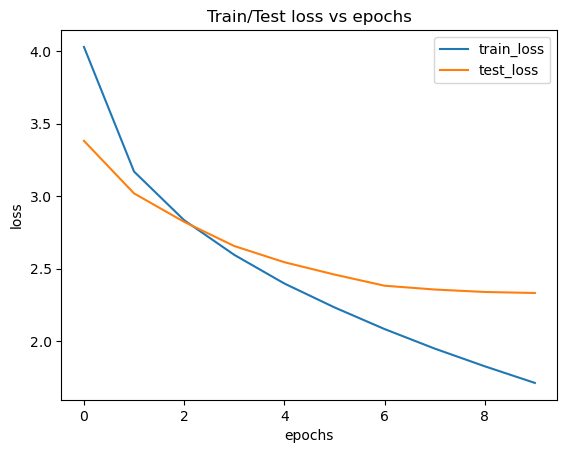

In [31]:
plt.plot(range(10), train_losses, label="train_loss")
plt.plot(range(10), test_losses, label="test_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Train/Test loss vs epochs")
plt.legend();